# Project 2: Mini deep-learning framework

You should be able to copy paste everything here to test.py

In [1]:
#!/usr/bin/env python3
""" File to solve the second miniproject which is the design of a framework """

import math
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch import empty

__author__ = 'Eugène Lemaitre, Natalie Bolón Brun, Louis Munier'
__version__ = '0.1'

torch.set_grad_enabled(False)

In [2]:
from Linear import Linear
from Activation import Tanh, Relu, Sigmoid
from Loss import LossMSE, CrossEntropy
from Optimizers import Sgd, DecreaseSGD
from Sequential import Sequential

In [3]:
def compute_number_error(output_one_hot, target_one_hot):
    output = output_one_hot.argmax(dim=1)
    target = target_one_hot.argmax(dim=1)
    nb_of_error = (output != target).sum()
    return nb_of_error

## Data generation

In [4]:
def generate_disc_set(nb):
    X = empty(nb,2).uniform_(0,1)
    Y = empty(X.size())
    
    Y[:,0] = ((X - 0.5).norm(dim=1)  >  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    Y[:,1] = ((X - 0.5).norm(dim=1)  <=  math.sqrt(1/(2*math.pi))).type(torch.LongTensor)
    
    return X, Y

def plot_disc(data_in, data_target, title):
    plt.scatter(data_in[(data_target[:,1]==1),0] ,data_in[(data_target[:,1]==1),1], color = "c", s=20)
    plt.scatter(data_in[(data_target[:,1]==0),0] ,data_in[(data_target[:,1]==0),1], color = "g", s=20)
    plt.title(title)
    plt.legend(["1", "0"] )
    plt.show()
    
def plot_result(data_in, data_target, data_class):
    one_id_as_one = torch.mul( (data_target[:,1]==1), (data_class ==1 ))
    one_id_as_zero = torch.mul( (data_target[:,1]==1), (data_class ==0 ))
    zero_id_as_one = torch.mul( (data_target[:,1]==0), (data_class ==1 ))
    zero_id_as_zero = torch.mul( (data_target[:,1]==0), (data_class ==0 ))
    
    plt.scatter(data_in[one_id_as_one,0] ,data_in[one_id_as_one,1], color = "c", s=20)
    plt.scatter(data_in[zero_id_as_zero,0] ,data_in[zero_id_as_zero,1], color = "g", s=20)
    plt.scatter(data_in[one_id_as_zero,0] ,data_in[one_id_as_zero,1], color = "r", s=20)
    plt.scatter(data_in[zero_id_as_one,0] ,data_in[zero_id_as_one,1], color = "y", s=20)
    
    plt.title("Result on train data")
    plt.legend(["1 id as 1", "0 id as 0", "1 id as 0", "0 id as 1"] )
    plt.show()

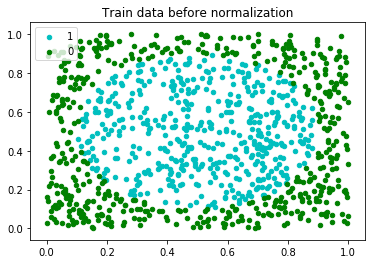

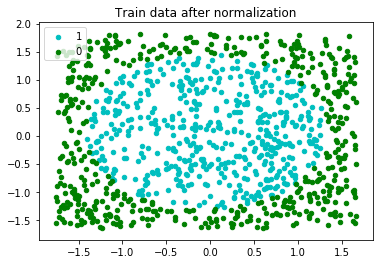

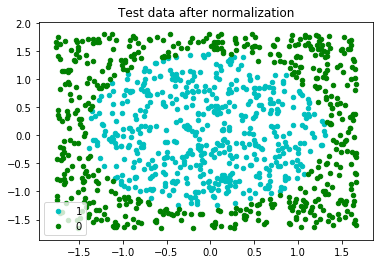

In [5]:
Sample_number = 1000
train_input, train_target = generate_disc_set(Sample_number)
test_input, test_target = generate_disc_set(Sample_number)


plot_disc(train_input, train_target, "Train data before normalization")

mu, std = train_input.mean(0), train_input.std(0)
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

plot_disc(train_input, train_target, "Train data after normalization")
plot_disc(test_input, test_target, "Test data after normalization")

## Model 1

In [6]:
hidden_nb = 25

linear_1 = Linear(2, hidden_nb)
relu_1 = Relu()
linear_2 = Linear(hidden_nb, hidden_nb)
relu_2 = Relu()
linear_3 = Linear(hidden_nb, hidden_nb)
relu_3 = Relu()
linear_4 = Linear(hidden_nb, 2)
loss = CrossEntropy()

model = Sequential(linear_1, relu_1, linear_2, relu_2, linear_3, relu_3, linear_4, loss=CrossEntropy()) 
       
std = 0.1
eta = 3e-1
batch_size = 200
epochs_number = 1000

model.normalize_parameters(mean=0, std=std)
optimizer = Sgd()

for epochs in range(0, epochs_number):
    for b in range(0, Sample_number, batch_size):
        output = model.forward(train_input.narrow(0, b, batch_size))
        loss_value =  model.compute_loss(output, train_target.narrow(0, b, batch_size))
        model.backward()
        
        optimizer.optimize(eta, model.sequence)
    
    if epochs%50 == 0:
        print(epochs, ": ", loss_value.item())

0 :  0.6916894316673279
50 :  0.10010863840579987
100 :  0.05747131258249283
150 :  0.056609801948070526
200 :  0.0882098376750946
250 :  0.07143829017877579
300 :  0.06787780672311783
350 :  0.05983031913638115
400 :  0.05575378239154816
450 :  0.045292358845472336
500 :  0.039604492485523224
550 :  0.028359374031424522
600 :  0.044291991740465164
650 :  0.03851013258099556
700 :  0.026427000761032104
750 :  0.023155517876148224
800 :  0.14045776426792145
850 :  0.012073974125087261
900 :  0.020936889573931694
950 :  0.015449218451976776



 
Loss:  0.015944337472319603
Number of errors:  8

 


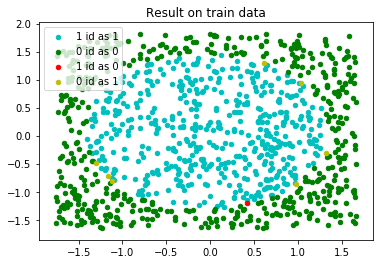

In [9]:
output = model.forward(train_input)
l = model.compute_loss(output, train_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, train_target).item())
print("\n ")


id_class_train = output.argmax(dim=1)
plot_result(train_input, train_target, id_class_train)


 
Loss:  0.03184570372104645
Number of errors:  11

 


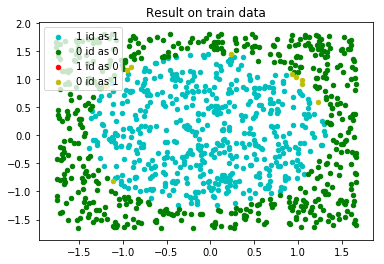

In [10]:
output = model.forward(test_input)
l = model.compute_loss(output, test_target)

print("\n ")
print("Loss: ", l.item())
print("Number of errors: ", compute_number_error(output, test_target).item())
print("\n ")


id_class_test = output.argmax(dim=1)
plot_result(test_input, test_target, id_class_test)
